In [8]:
# Import libraries
import pandas as pd
import tensorflow as tf
from tensorflow import keras
# pd.plotting.register_matplotlib_converters()
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from datetime import datetime
from sklearn.ensemble import IsolationForest
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from pylab import rcParams

In [4]:
# Read data
df = pd.read_csv('train_1.csv/train_1.csv')

# Fill missing values
df = df.fillna(0)

# Reshaping the dataframe
df_reshaped = pd.melt(df,id_vars=['Page'],var_name='Date',value_name='Views')

# Setting 'Date' column as the index 
df_reshaped['Date'] = pd.DatetimeIndex(df_reshaped['Date'])
df_reshaped = df_reshaped.set_index('Date')

In [6]:
top_page_df = df_reshaped[df_reshaped.Page == 'Main_Page_en.wikipedia.org_all-access_all-agents']
top_page_df = top_page_df[['Views']]
top_page_df['Views'] = top_page_df['Views'].div(1000000).round(2)
top_page_df.head()

,Views
Date,
2015-07-01,20.38
2015-07-02,20.75
2015-07-03,19.57
2015-07-04,20.44
2015-07-05,20.77


In [9]:
isolation_forest_model = IsolationForest(contamination=0.08)
isolation_forest_model.fit(top_page_df)
top_page_df['anomaly'] = isolation_forest_model.predict(top_page_df)

top_page_df['new_views'] = top_page_df.apply(lambda row: row.Views if row.anomaly == 1 else None, axis='columns')
top_page_df = top_page_df.assign(rolling_mean=top_page_df.new_views.fillna(top_page_df.new_views.rolling(30,min_periods=1).mean()))
top_page_df = top_page_df.drop(columns=['Views','anomaly','new_views']).rename(columns={'rolling_mean':'Views'})

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


In [28]:
train = top_page_df[:'2016-09']
test = top_page_df['2016-10':]

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 7

X_train, y_train = create_dataset(train, train.Views, time_steps)
X_test, y_test = create_dataset(test, test.Views, time_steps)

In [29]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
  units=128,
  input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dense(units=1))
model.compile(
  loss='mean_squared_error',
  optimizer=keras.optimizers.Adam(0.001)
)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [30]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

Train on 405 samples, validate on 46 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
405/405 [==============================] - 8s 19ms/sample - loss: 230.6119 - val_loss: 244.2713
Epoch 2/30
405/405 [==============================] - 1s 3ms/sample - loss: 62.4699 - val_loss: 98.6529
Epoch 3/30
405/405 [==============================] - 1s 2ms/sample - loss: 12.9125 - val_loss: 48.3916
Epoch 4/30
405/405 [==============================] - 1s 3ms/sample - loss: 4.1049 - val_loss: 34.9074
Epoch 5/30
405/405 [==============================] - 1s 2ms/sample - loss: 2.7345 - val_loss: 29.6969
Epoch 6/30
405/405 [==============================] - 1s 3ms/sample - loss: 2.5297 - val_loss: 27.9495
Epoch 7/30
405/405 [==============================] - 1s 3ms/sample - loss: 2.5071 - val_loss: 27.5004
Epoch 8/30
405/405 [==============================] - 1s 3ms/sample - loss: 2.5061 - val_loss: 27.4431
Epoch 9/30
405/405 [==============================] - 2s 4ms/sample - loss: 2

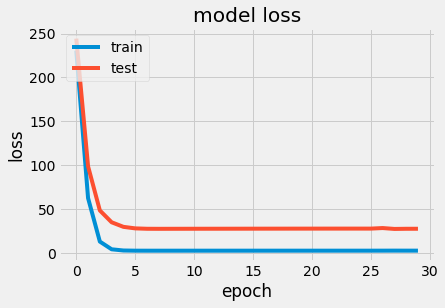

In [33]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [34]:
y_pred = model.predict(X_test)

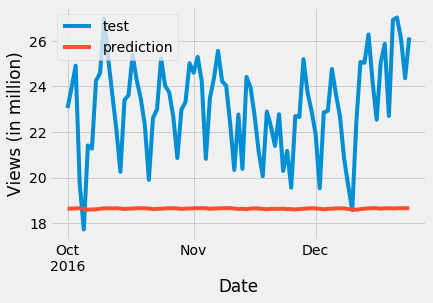

In [82]:
fig,ax=plt.subplots()
pd.DataFrame({'Date':test.index[:y_test.shape[0]],'Views':y_test}).plot('Date',ax=ax)
pd.DataFrame({'Date':test.index[:y_pred.shape[0]],'Views':y_pred.flatten()}).plot('Date',ax=ax)
plt.legend(['test', 'prediction'], loc='upper left')
plt.ylabel('Views (in million)')
plt.show()
# a.info()